# Problem analysis

# Download datasets

In [1]:
from glob import glob
flickr30k_folder = 'Flickr30k-images-preprocessed'
! rm -rf sample_data

In [2]:
! mkdir "$flickr30k_folder" && \
gdown --id "10c0Xruu2wAE-FpQEIlXm17HlwQAJKKVM" && \
unzip -qo flickr30k-images-preprocessed.zip -d "$flickr30k_folder" && \
rm flickr30k-images-preprocessed.zip

mkdir: cannot create directory ‘Flickr30k-images-preprocessed’: File exists


In [3]:
# Unfiltered dataset: 1yYk3ZyxXdP2KHjE31fSTFGCNYb2QbSHe
# Filtered dataset: 1bR_BE-ZZSXW1URBJqPIMFo9VLODYb4_k

films_data = {
    "Ghibli": "1bR_BE-ZZSXW1URBJqPIMFo9VLODYb4_k"
}
ghibli_index = 0
real_folder = 'real'
smooth_folder = 'smooth'
mask_folder = 'mask'

def load_data(id, name):
  ! [ ! -d "$name" ] && mkdir -p "$name" && cd "$name" && gdown --id "$id"
  zip_files = glob(f'{name}/*.zip')
  for zip_file in zip_files:
    #! zip -FF "$zip_file" -O "temp.zip"
    #! unzip -qo "temp.zip" -d "$name"  # add to fix broken zip TODO remove
    ! unzip -qo "$zip_file" -d "$name"
    ! rm "$zip_file"
    ! rm "temp.zip" # add to fix broken zip TODO remove
  return name

folders = [load_data(id_drive, studio_name) for studio_name, id_drive in films_data.items()]
print(folders)

['Ghibli']


Folder structure:
```bash
.
├── Studio_Name
|   ├── real
|   |   └── Movie_Name_1
|   |       ├── Scene-1.0.left.jpg
|   |       ├── Scene-1.0.right.jpg
|   |       ...
|   |       └──
|   |   
|   └── smooth
|       └── Movie_Name_2
|           ├── Scene-1.0.left.jpg
|           ├── Scene-1.0.right.jpg
|           ...
|           └──
├── Studio_Name_2
...
└──
```

# Import

In [4]:
import numpy as np
import pandas as pd
import math
import random
import psutil
import pickle
import shutil
import os
import csv
from os import path
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
from PIL import Image
from IPython.display import Image as ImageGif
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec, LeakyReLU, Input, Conv2D, Activation, Concatenate, Conv2DTranspose, BatchNormalization, AveragePooling2D, Add
from tensorflow import pad
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator
! pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import CyclicalLearningRate

# Plot functions

In [5]:
def plot_grid(images, columns, show_axis=False, labels=None):
  if len(images) == 0 or columns <= 0:
    return
  scale = 1.5
  height = (1 + math.ceil(len(images) / columns) * 2) * scale
  width = (columns * 4) * scale
  dpi = min(max(images[0].shape[0], images[0].shape[1]) // 2, 480)
  fig = plt.figure(figsize=(width, height), dpi=dpi)
  fig.subplots_adjust(hspace=0.4)
  for index, img in enumerate(images, start=1):
    if 'float' in img.dtype.name:
      img = (img * 255).astype('uint8')
    sp = fig.add_subplot(math.ceil(len(images) / columns), columns, index)
    if not show_axis:
      plt.axis('off')
    if len(np.shape(img)) == 2 or (len(np.shape(img)) > 2 and np.shape(img)[2] == 1):
      img = img.squeeze()
      plt.imshow(img, cmap='gray', vmin=0.0, vmax=255.0)
    else:
      plt.imshow(img, vmin=0.0, vmax=255.0)
    if labels is not None:
      l = len(labels)
      sp.set_title(labels[(index-1) % l], fontsize=10)
    else:
      sp.set_title(index, fontsize=10)
  plt.show()

def float_to_int_images(outputs):
  return [np.clip(output * 255 + 0.5, 0, 255).astype(np.uint8) for output in outputs]

def image_name_to_number(name):
  return int("".join(list(filter(str.isdigit, name))))

def save_plot_grid(images, columns, name, directory='', ext='.png', show_axis=False, labels=None, title=''):
  if len(images) == 0 or columns <= 0:
    return
  scale = 1.5
  height = (1 + math.ceil(len(images) / columns) * 2) * scale
  width = (columns * 4) * scale
  dpi = min(max(images[0].shape[0], images[0].shape[1]) // 2, 480)
  fig = plt.figure(figsize=(width, height), dpi=dpi)
  fig.subplots_adjust(hspace=0.4)
  for index, img in enumerate(images, start=1):
    if 'float' in img.dtype.name:
      img = (img * 255).astype('uint8')
    sp = fig.add_subplot(math.ceil(len(images) / columns), columns, index)
    if not show_axis:
      plt.axis('off')
    if len(np.shape(img)) == 2 or (len(np.shape(img)) > 2 and np.shape(img)[2] == 1):
      img = img.squeeze()
      plt.imshow(img, cmap='gray', vmin=0.0, vmax=255.0)
    else:
      plt.imshow(img, vmin=0.0, vmax=255.0)
    if labels is not None:
      l = len(labels)
      sp.set_title(labels[(index-1) // columns], fontsize=14)
    else:
      sp.set_title(index, fontsize=10)
  if title != '':
    fig.suptitle(title, fontsize=16)
  fig.savefig(os.path.join(directory, f'{name}{ext}'))
  plt.close(fig)

# Global parameters

In [6]:
# Dimension after the preprocess stage
# Should be the dimension expected by the network and the loss functions
input_shape = (224, 224, 3)

# Batch size used for training and fetching images
batch_size = 16

# Images are split between train+validation and test set at this proportion
validation_split = 0.2

# Dataset loading and preprocessing

In [7]:
def lambda_generator(batches, λ=lambda x: x):
  for batch in batches:
    if type(batch) is tuple:
      batch, labels = batch
      yield [λ(i) for i in batch], labels
    else:
      yield [λ(i) for i in batch]

def random_merge_generator(it_1, it_2, p=0.5):
  while True:
    rand = np.random.random()
    it, other = (it_1, it_2) if rand < p else (it_2, it_1)
    try:
      yield next(it)
    except StopIteration:
      while True:
        yield next(other)

In [8]:
norm_mean = np.asfarray([0.485, 0.456, 0.406])
norm_std = np.asfarray([0.229, 0.224, 0.225])

def normalize(img):
  return (img - norm_mean) / norm_std
def unnormalize(img):
  return tf.clip_by_value(img * norm_std + norm_mean, 0.0, 1.0)
def rescale_and_normalize(img):
  return normalize(img / 255.0)

def generated_to_images(outputs):
  return [unnormalize(output).numpy() for output in outputs]

def test():
  a = np.asfarray([[[1.0, 0.5, 0.5], [0.0, 0.1, 0.9]], [[0.5, 0.6, 0.7], [1.0, 0.1, 0.2]]])
  b = normalize(a)
  c = unnormalize(b)
  assert np.linalg.norm(c - a) < 0.00001
test()

2021-10-02 14:45:42.738943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-02 14:45:42.756813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-02 14:45:42.757297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-02 14:45:42.771004: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
data_generator_settings = {
    'data_format' : 'channels_last',
    'validation_split' : validation_split,
    'preprocessing_function' : rescale_and_normalize,
    #'rescale' : 1.0 / 255,
    'horizontal_flip' : True
}

data_flow_settings = {
    'color_mode' : 'rgb',
    'batch_size' : batch_size,
    'shuffle' : True,
    'seed' : 42, # Mandatory to allign shuffles between cartoon_real and cartoon_smooth
    'class_mode' : None,
    'interpolation' : 'bilinear',
    'target_size' : (input_shape[0], input_shape[1])
}

def cartoon_real_generator(subset='training'):
  cartoon_real_gen = ImageDataGenerator(
    **data_generator_settings
  )
  return cartoon_real_gen.flow_from_directory(
        **data_flow_settings,
        # Ghibli cartoon
        directory = path.join(folders[ghibli_index], real_folder),
        subset = subset
      )

def cartoon_real_validation_generator():
  return cartoon_real_generator('validation')

def cartoon_smooth_generator(subset='training'):
  cartoon_smooth_gen = ImageDataGenerator(
    **data_generator_settings
  )
  return cartoon_smooth_gen.flow_from_directory(
        **data_flow_settings,
        # Ghibli cartoon
        directory = path.join(folders[ghibli_index], smooth_folder),
        subset = subset
      )
  
def cartoon_smooth_validation_generator():
  return cartoon_smooth_generator('validation')

def real_generator(subset='training'):
  real_gen = ImageDataGenerator(
      **data_generator_settings
  )
  return real_gen.flow_from_directory(
      **data_flow_settings,
      # Flickr30k images
      directory=flickr30k_folder,
      subset=subset
  )

def real_validation_generator():
  return real_generator('validation')

def smooth_label_generator(subset='training'):
  def mask_to_label(mask):
    return (mask <= 0).astype(np.float32)
  label_data_generator_settings = {**data_generator_settings}
  label_data_generator_settings['preprocessing_function'] = mask_to_label
  smooth_mask_gen = ImageDataGenerator(
    **label_data_generator_settings
  )
  label_data_flow_settings = {**data_flow_settings}
  label_data_flow_settings['target_size'] = (56, 56) # Discriminator label size
  label_data_flow_settings['color_mode'] = 'grayscale'
  return smooth_mask_gen.flow_from_directory(
      **label_data_flow_settings,
      # Mask images
      directory=path.join(folders[ghibli_index], mask_folder),
      subset=subset
  )

def smooth_label_validation_generator(subset='training'):
  return smooth_label_generator('validation')

In [10]:
gen = cartoon_real_generator()
batches_per_epoch = len(gen)
print("Batches per epoch:", batches_per_epoch)
del gen

Found 20924 images belonging to 10 classes.
Batches per epoch: 1308


Found 20924 images belonging to 10 classes.
Expected steps per epoch: 1308


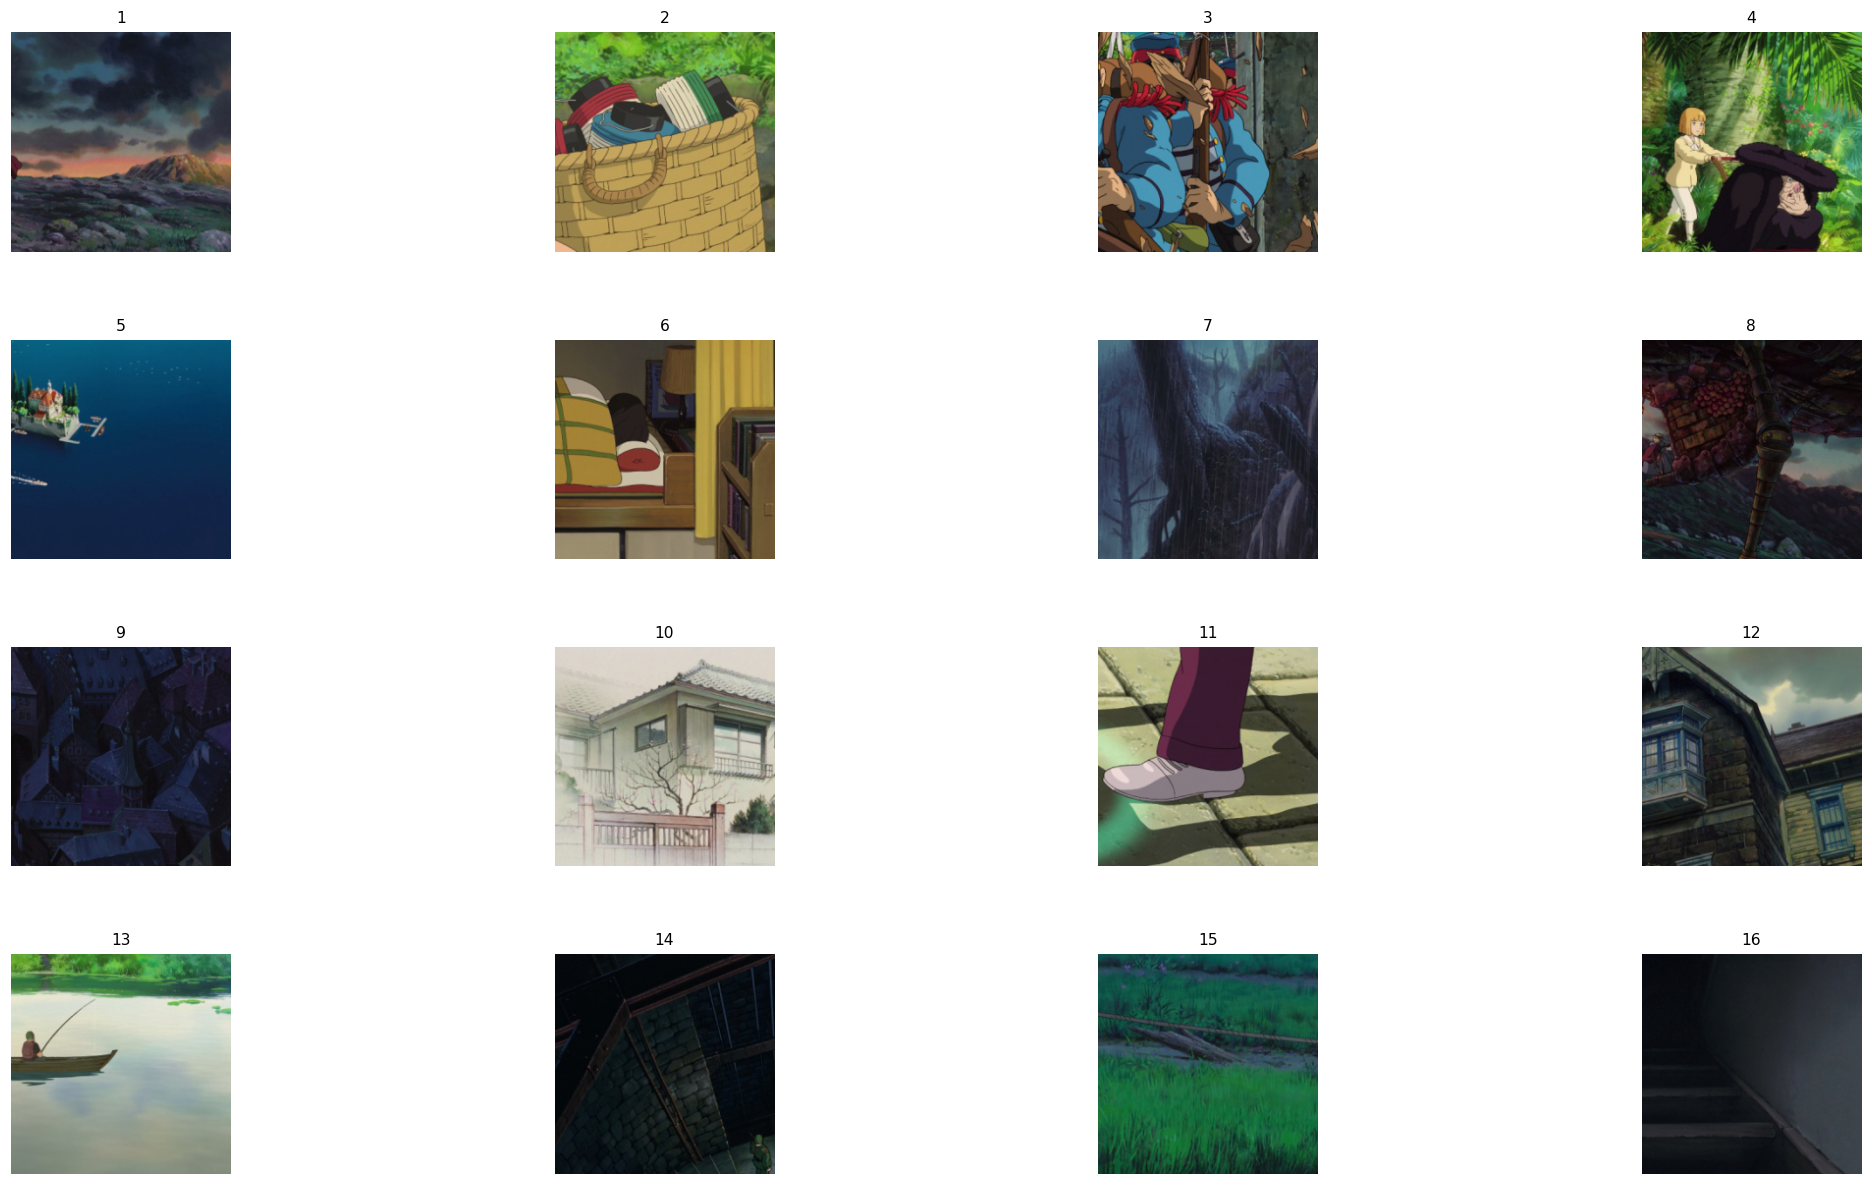

In [11]:
test_cartoon_real_flow = cartoon_real_generator()
print("Expected steps per epoch:", len(test_cartoon_real_flow))
plot_grid(generated_to_images(next(test_cartoon_real_flow)), 4)
del test_cartoon_real_flow

Found 20924 images belonging to 10 classes.
Expected steps per epoch: 1308


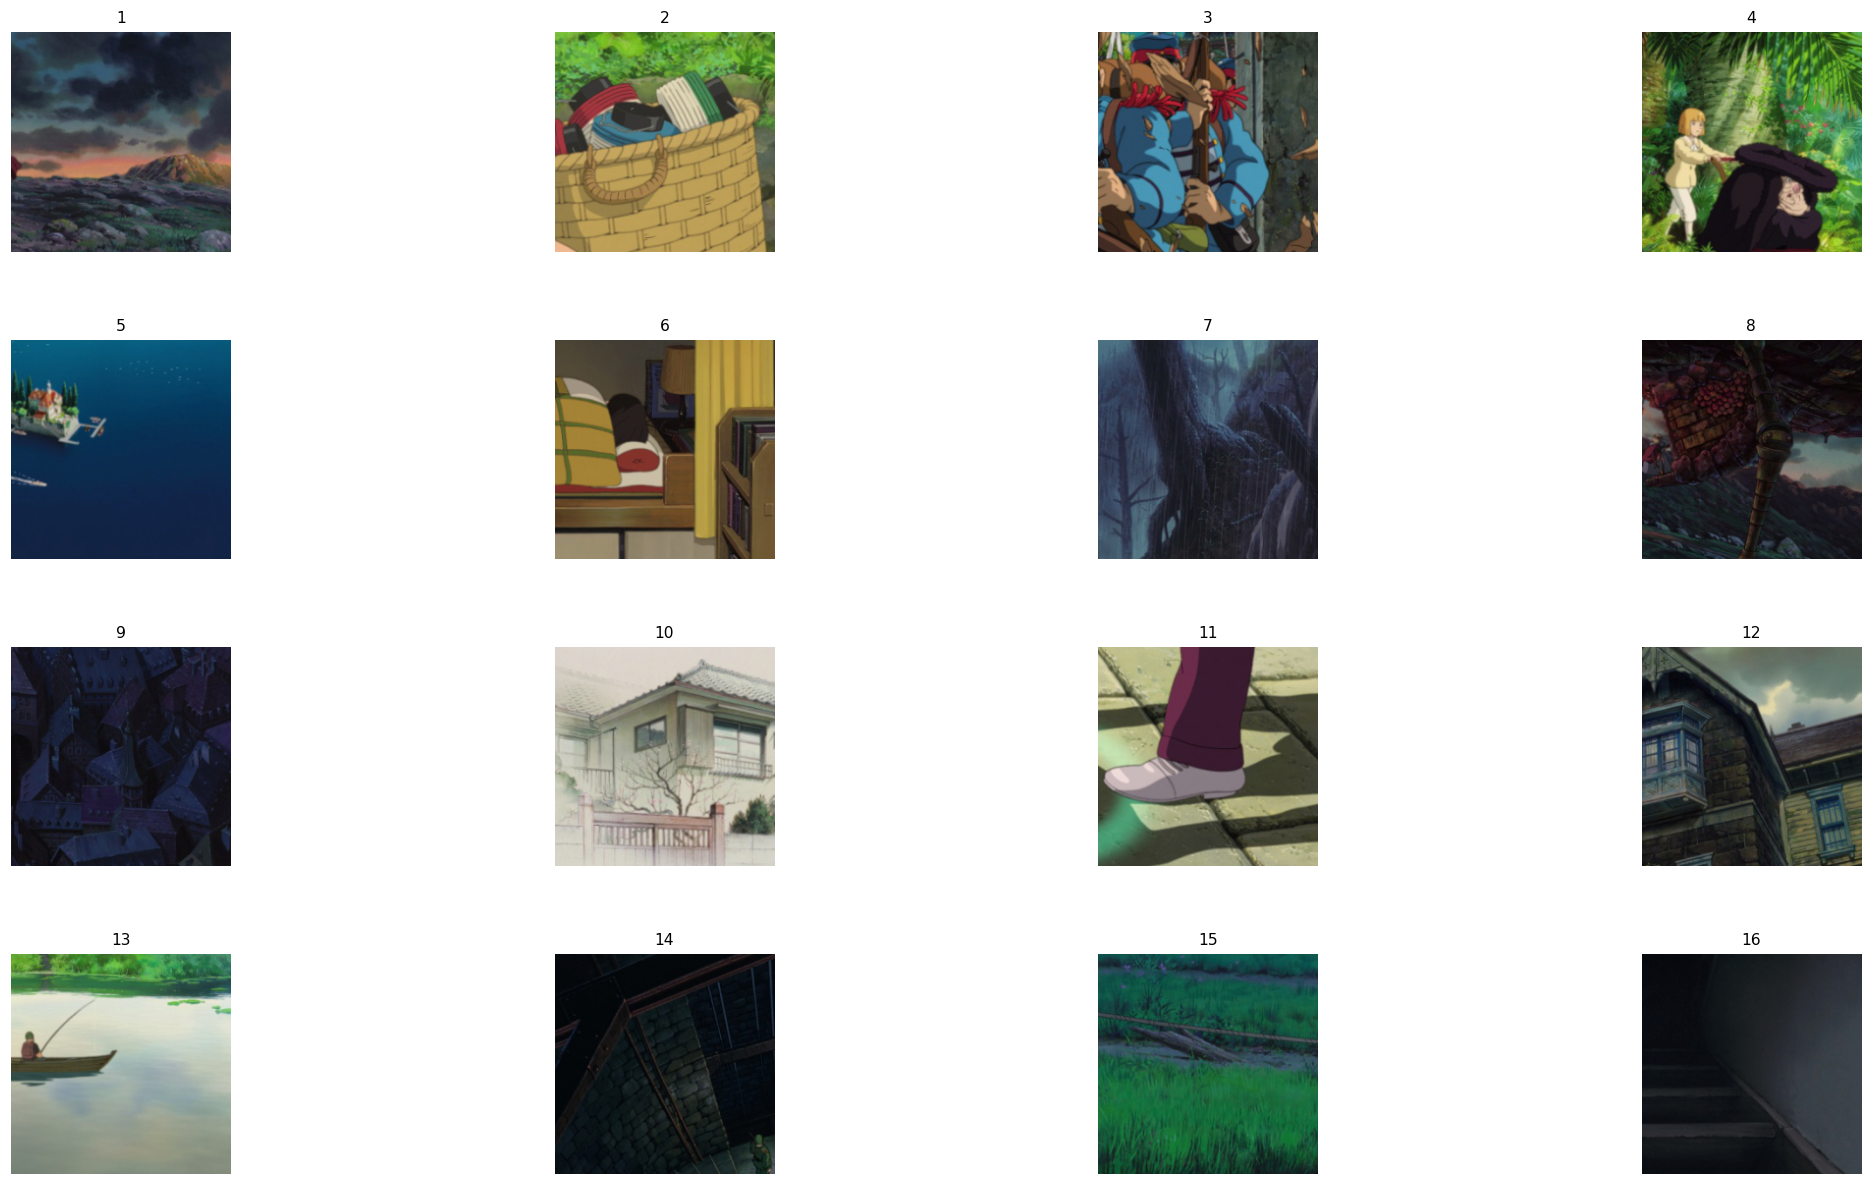

In [12]:
test_cartoon_edge_fake_flow = cartoon_smooth_generator()
print("Expected steps per epoch:", len(test_cartoon_edge_fake_flow))
plot_grid(generated_to_images(next(test_cartoon_edge_fake_flow)), 4)
del test_cartoon_edge_fake_flow

Found 36645 images belonging to 1 classes.
Expected steps per epoch: 2291


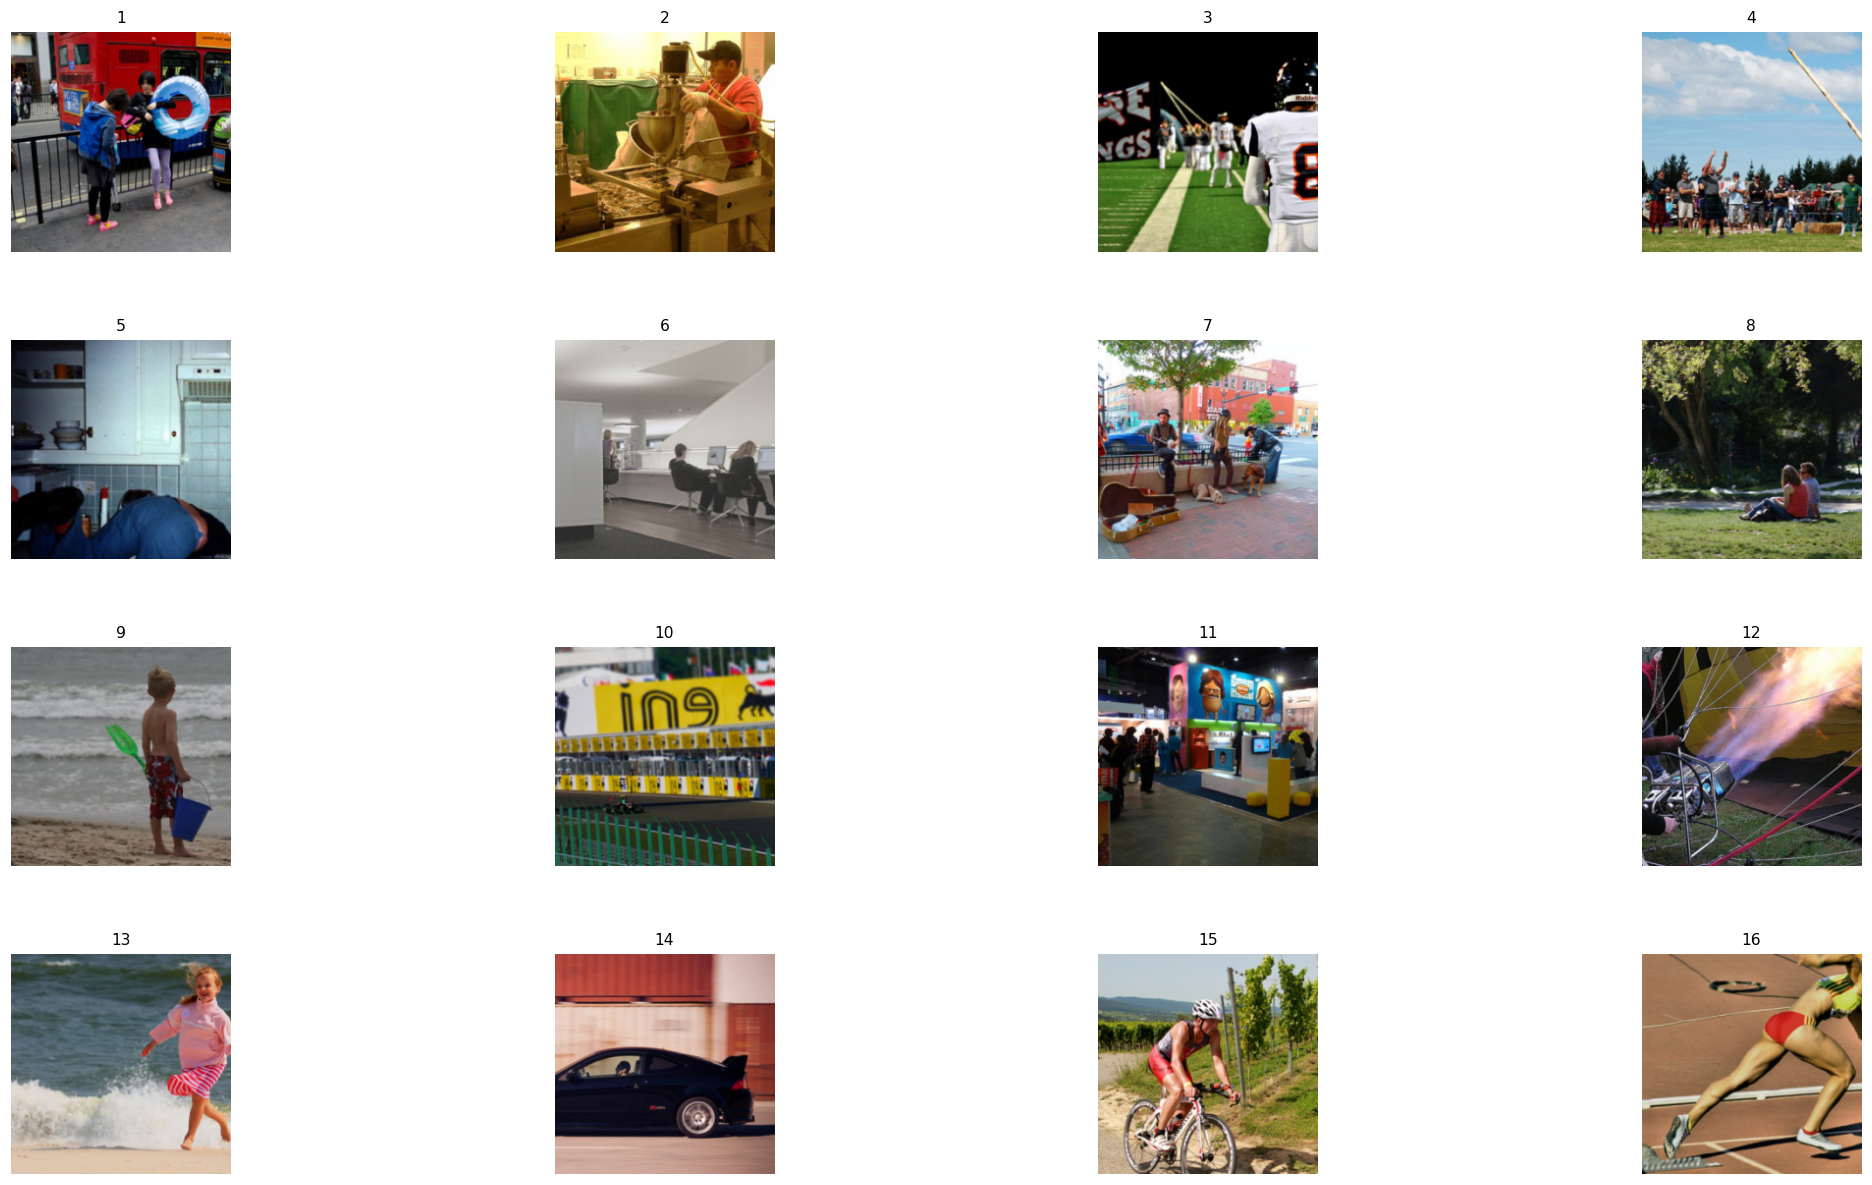

In [13]:
test_real_flow = real_generator()
print("Expected steps per epoch:", len(test_real_flow))
plot_grid(generated_to_images(next(test_real_flow)), 4)
del test_real_flow

Found 20924 images belonging to 10 classes.
Expected steps per epoch: 1308


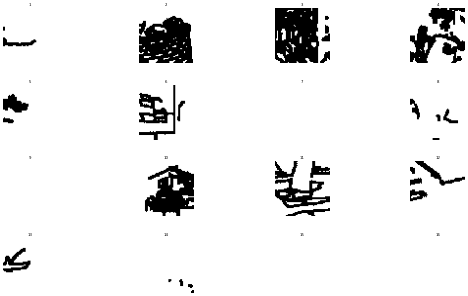

In [14]:
test_mask_flow = smooth_label_generator()
print("Expected steps per epoch:", len(test_mask_flow))
plot_grid(next(test_mask_flow), 4)
del test_mask_flow

# Cartoon-GAN

## Custom Convolutional Layers

In [15]:
class ReflectionPadding2D(Layer):
  def __init__(self, padding=(1, 1), **kwargs):
    self.padding = tuple(padding)
    # self.input_spec = [InputSpec(ndim=4)]
    super(ReflectionPadding2D, self).__init__(**kwargs)

  def compute_output_shape(self, s):
    if s[1] == None:
      return (None, None, None, s[3])
    return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

  def call(self, x, mask=None):
    w_pad, h_pad = self.padding
    return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

  def get_config(self):
    config = super(ReflectionPadding2D, self).get_config()
    return config

In [16]:
class Conv2DReflection3x3(Layer):
  def __init__(self, features, stride=1):
    super().__init__()
    self.reflectionPadding2D = ReflectionPadding2D()
    self.conv2d = Conv2D(features, (3,3), strides=(stride, stride), padding='valid', use_bias=False)

  def call(self, inputs, training=True):
    x = self.reflectionPadding2D(inputs, training=training)
    return self.conv2d(x, training=training)

## Discriminator
Based on the Cartoon-GAN discriminator, available at [this link](https://github.com/FilipAndersson245/cartoon-gan/blob/master/models/discriminator.py).

In [47]:
# define the discriminator model
def define_discriminator(image_shape):
  alpha = 0.2
  epsilon = 1e-5
  momentum = 0.1

  # source image input
  in_image = Input(shape=image_shape)

  # k3n32s1
  d = Conv2DReflection3x3(32, stride=1)(in_image)
  d = LeakyReLU(alpha=alpha)(d)

  # k3n64s2
  d = Conv2DReflection3x3(64, stride=2)(d)
  d = LeakyReLU(alpha=alpha)(d)
  # k3n128s1
  d = Conv2DReflection3x3(128, stride=1)(d)
  d = BatchNormalization(epsilon=epsilon, momentum=momentum)(d)
  d = LeakyReLU(alpha=alpha)(d)

  # k3n128s2
  d = Conv2DReflection3x3(128, stride=2)(d)
  d = LeakyReLU(alpha=alpha)(d)
  # k3n256s1
  d = Conv2DReflection3x3(256, stride=1)(d)
  d = BatchNormalization(epsilon=epsilon, momentum=momentum)(d)
  d = LeakyReLU(alpha=alpha)(d)

  # feature construction block
  # k3n256s1
  #d = Conv2DReflection3x3(256, stride=1)(d)
  #d = BatchNormalization(epsilon=epsilon, momentum=momentum)(d)
  #d = LeakyReLU(alpha=alpha)(d)

  # patch output
  d = Conv2DReflection3x3(1, stride=1)(d)
  #d = tf.keras.activations.sigmoid(d)

  # define model
  model = Model(in_image, d, name='Discriminator')
  return model

D = define_discriminator(input_shape)

In [48]:
#plot_model(D, show_shapes=True, expand_nested=True)
D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_reflection3x3_50 (Con (None, 224, 224, 32)      864       
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_reflection3x3_51 (Con (None, 112, 112, 64)      18432     
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_reflection3x3_52 (Con (None, 112, 112, 128)     73728     
_________________________________________________________________
batch_normalization_44 (Batc (None, 112, 112, 128)   

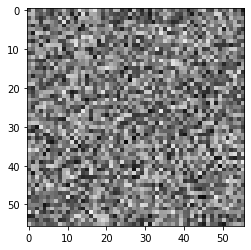

In [49]:
noise = tf.random.normal([1, *input_shape])
label_image = D(noise, training=True)

plt.imshow(tf.sigmoid(label_image[0, :, :, 0]), cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

## Generator
Based on the Cartoon-GAN generator, available at [this link](https://github.com/FilipAndersson245/cartoon-gan/blob/master/models/generator.py).

In [50]:
# define the generator model
def define_generator(image_shape):
  alpha = 0.2
  epsilon = 1e-5
  momentum = 0.1

  # source image input
  in_image = Input(shape=image_shape)

  # flat block
  # k7n64s1
  g = Conv2D(64, (7,7), strides=1, padding='same', use_bias=False)(in_image)
  g = BatchNormalization(epsilon=epsilon, momentum=momentum)(g)
  g = LeakyReLU(alpha=alpha)(g)

  def down_block(x, n_features):
    # k3n?s2
    x = Conv2DReflection3x3(n_features, stride=2)(x)
    # k3n?s1
    x = Conv2DReflection3x3(n_features, stride=1)(x)
    x = BatchNormalization(epsilon=epsilon, momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    return x

  # 1st down block
  g = down_block(g, 128)

  # 2nd down block
  g = down_block(g, 256)

  def resiual_block(x):
    skip = x
    # k3n256s1
    x = Conv2DReflection3x3(256, stride=1)(x)
    x = BatchNormalization(epsilon=epsilon, momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    # k3n256s1
    x = Conv2DReflection3x3(256, stride=1)(x)
    x = BatchNormalization(epsilon=epsilon, momentum=momentum)(x)
    x = Add()([x, skip])
    x = LeakyReLU(alpha=alpha)(x)
    return x

  for _ in range(8):
    g = resiual_block(g)

  def up_block(x, n_features):
    # k3n?s1/2
    x = Conv2DTranspose(n_features, (3,3), strides=2)(x)
    x = AveragePooling2D(pool_size=(2,2), strides=1)(x)
    # k3n?s1
    x = Conv2DReflection3x3(n_features, stride=1)(x)
    x = BatchNormalization(epsilon=epsilon, momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    return x

  # 1st up block
  g = up_block(g, 128)

  # 2nd up-block
  g = up_block(g, 64)

  # k7n3s1
  output = Conv2D(3, (7,7), strides=1, padding='same')(g)

  # define model
  model = Model(in_image, output, name='Generator')
  return model


G = define_generator(input_shape)

In [51]:
#plot_model(G, show_shapes=True, expand_nested=True)
G.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 224, 224, 64) 9408        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 224, 224, 64) 256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_52 (LeakyReLU)      (None, 224, 224, 64) 0           batch_normalization_46[0][0]     
__________________________________________________________________________________________

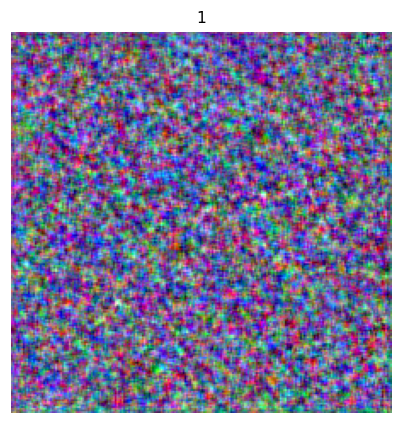

In [52]:
noise = tf.random.normal([1, *input_shape])
generated_image = define_generator(input_shape)(noise, training=True)
plot_grid(generated_to_images(generated_image), 1)

## Loss functions

### Binary Cross Entropy

In [53]:
def BCEWithLogitsLoss():
  bce = tf.keras.losses.BinaryCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  return lambda x, y: bce(y, x)

def BCELoss():
  bce = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  return lambda x, y: bce(y, x)

def test():
  a = tf.ones((10, 64))
  b = tf.fill((10, 64), 1.5)
  loss = BCEWithLogitsLoss()
  assert abs(loss(b, a).numpy() - 0.2014133) <= 1e-8

  loss = BCELoss()
  assert abs(loss(a, a).numpy() - 0.0) <= 1e-8
test()

### Adversarial Loss
Also called Discriminator loss.

In [54]:
# Penalizes smoothed edges
class AdversarialLoss:
  def __init__(self, cartoon_labels, fake_cartoon_labels):
    self.base_loss = BCEWithLogitsLoss()
    self.cartoon_labels = cartoon_labels
    self.fake_cartoon_labels = fake_cartoon_labels

  def __call__(self, cartoons_outputs, generated_fakes_outputs, cartoon_edge_fakes_outputs, cartoon_edge_fake_labels):
    D_cartoon_loss = self.base_loss(cartoons_outputs, self.cartoon_labels)
    D_generated_fake_loss = self.base_loss(generated_fakes_outputs, self.fake_cartoon_labels)
    D_edge_fake_loss = self.base_loss(cartoon_edge_fakes_outputs, cartoon_edge_fake_labels)

    return D_cartoon_loss + D_generated_fake_loss + D_edge_fake_loss

# Ignores smoothed edges
class SimplifiedAdversarialLoss:
  def __init__(self, cartoon_labels, fake_cartoon_labels):
    self.base_loss = BCEWithLogitsLoss()
    self.cartoon_labels = cartoon_labels
    self.fake_cartoon_labels = fake_cartoon_labels

  def __call__(self, cartoons_outputs, generated_fakes_outputs):
    D_cartoon_loss = self.base_loss(cartoons_outputs, self.cartoon_labels)
    D_generated_fake_loss = self.base_loss(generated_fakes_outputs, self.fake_cartoon_labels)

    return D_cartoon_loss + D_generated_fake_loss

def test():
  loss = AdversarialLoss(np.ones((10, 56, 56)), np.zeros((10, 56, 56)))
  cartoon_edge_fake_labels = np.zeros((10, 56, 56))
  cartoon = tf.fill((10, 56, 56), 0.6)
  gf = tf.fill((10, 56, 56), 0.4)
  cartoon_edge = tf.fill((10, 56, 56), 0.3)
  l1 = loss(cartoon, gf, cartoon_edge, cartoon_edge_fake_labels)

  cartoon = tf.fill((10, 56, 56), 0.9)
  gf = tf.fill((10, 56, 56), 0.3)
  cartoon_edge = tf.fill((10, 56, 56), 0.2)
  l2 = loss(cartoon, gf, cartoon_edge, cartoon_edge_fake_labels)

  cartoon = tf.fill((10, 56, 56), 0.99)
  gf = tf.fill((10, 56, 56), 0.01)
  cartoon_edge = tf.fill((10, 56, 56), 0.01)
  l3 = loss(cartoon, gf, cartoon_edge, cartoon_edge_fake_labels)
  assert l1 > l2 > l3 > 0
  
  loss = SimplifiedAdversarialLoss(np.ones((10, 56, 56)), np.zeros((10, 56, 56)))
  cartoon = tf.fill((10, 56, 56), 0.6)
  gf = tf.fill((10, 56, 56), 0.4)
  l1 = loss(cartoon, gf)

  cartoon = tf.fill((10, 56, 56), 0.9)
  gf = tf.fill((10, 56, 56), 0.3)
  l2 = loss(cartoon, gf)
  
  cartoon = tf.fill((10, 56, 56), 0.99)
  gf = tf.fill((10, 56, 56), 0.01)
  l3 = loss(cartoon, gf)
  assert l1 > l2 > l3 > 0
test()

### Content Loss
Used to force content fidelty in the generator.

In [55]:
vgg16_wights_path = 'ImageNet/Keras/weights/vgg16_imagenet.h5'
!curl https://raw.githubusercontent.com/ezavarygin/vgg16_pytorch2keras/master/vgg16_pytorch2keras.h5 \
  --create-dirs -o "$vgg16_wights_path"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56.1M  100 56.1M    0     0  17.3M      0  0:00:03  0:00:03 --:--:-- 17.3M


In [56]:
from tensorflow.keras.applications import vgg16

vgg16_model = vgg16.VGG16(include_top=False, 
                    weights=vgg16_wights_path, 
                    input_shape=input_shape,
                    )

vgg16_model.trainable = False
for l in vgg16_model.layers:
  l.trainable = False
vgg16_cut = Sequential(vgg16_model.layers[:16], name="ContentLoss_VGG16")
vgg16_cut.layers[14].activation = None # 14 is the last layer
vgg16_cut.trainable = False
vgg16_cut.summary()

class ContentLoss:
  def __init__(self):
    def perc(img):
      return vgg16_cut(img, training=False)
    self.perception = perc
  
  def __call__(self, outputs, targets):
    diff = self.perception(outputs) - self.perception(targets)
    k = tf.math.reduce_mean(tf.math.abs(diff))
    return k

def test():
  loss = ContentLoss()
  outputs = normalize(tf.fill((10, 224, 224, 3), 0.5))
  assert loss(outputs, outputs) == 0.0
  inputs = normalize(tf.fill((10, 224, 224, 3), 1.0))
  assert loss(outputs, inputs) > 0.0
  inputs = normalize(tf.fill((10, 224, 224, 3), 0.8))
  assert abs(loss(outputs, inputs) - 0.24931535) <= 1e-6
test()

Model: "ContentLoss_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256) 

### Generator Loss
Enforces both discriminator fooling and content fidelty from the original.

In [57]:
class GeneratorLoss:
  def __init__(self, cartoon_labels, omega=10):
    self.omega = tf.constant(omega, dtype=tf.float32)
    self.content_loss = ContentLoss()
    self.base_loss = BCEWithLogitsLoss()
    self.cartoon_labels = cartoon_labels
  
  def __call__(self, outputs, inputs, outputs_labels):
    return self.base_loss(outputs_labels, self.cartoon_labels) + self.omega * self.content_loss(outputs, inputs)

def test():
  loss = GeneratorLoss(tf.ones((10, 56, 56)), omega=100)
  outputs_labels = tf.fill((10, 56, 56), 1.0)
  outputs = tf.fill((10, 224, 224, 3), 0.0)
  assert loss(outputs, outputs, outputs_labels) == 0.31326172
  
  loss = GeneratorLoss(tf.ones((10, 56, 56)), omega=10)
  outputs_labels = tf.fill((10, 56, 56), 0.5)
  outputs = tf.fill((10, 224, 224, 3), 0.0)
  assert loss(outputs, outputs, outputs_labels) > 0.0
  
  loss = GeneratorLoss(tf.ones((10, 56, 56)), omega=100)
  outputs_labels = tf.fill((10, 56, 56), 1.0)
  outputs = tf.fill((10, 224, 224, 3), 0.0)
  inputs = tf.fill((10, 224, 224, 3), 1.0)
  assert loss(outputs, inputs, outputs_labels) > 0.0
test()

## Pretraining

In [58]:
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=1e-3,
    maximal_learning_rate=1e-2,
    step_size=batch_size * 2,
    scale_fn=lambda x: 1 / (2. ** (x - 1))
  )

In [59]:
def pretrain():
  crg = real_generator()
  x = map(lambda x: (x, x), crg)
  crvg = real_validation_generator()
  x_val = map(lambda x: (x, x), crvg)
  content_loss = ContentLoss()
  
  G.compile(optimizer=tfa.optimizers.AdamW(
              learning_rate=cyclical_learning_rate,#1e-3,
              beta_1=.5, beta_2=.99,
              weight_decay=1e-3
        ),
        loss=lambda img_true, img_pred: content_loss(img_pred, img_true),
        metrics=[]
       )
  G.fit(x=x,
        epochs=4,
        steps_per_epoch=len(crg),
        validation_data=x_val,
        validation_steps=len(crvg),
        shuffle=True
       )
  
pretrain()

Found 36645 images belonging to 1 classes.
Found 9161 images belonging to 1 classes.
Epoch 1/4
2291/2291 [==============================] - 1354s 590ms/step - loss: 2.5925 - val_loss: 1.6431
Epoch 2/4
2291/2291 [==============================] - 944s 412ms/step - loss: 1.2799 - val_loss: 26.6669
Epoch 3/4
2291/2291 [==============================] - 944s 412ms/step - loss: 1.1837 - val_loss: 1.5295
Epoch 4/4
2291/2291 [==============================] - 943s 412ms/step - loss: 1.1562 - val_loss: 1.5177


Found 36645 images belonging to 1 classes.


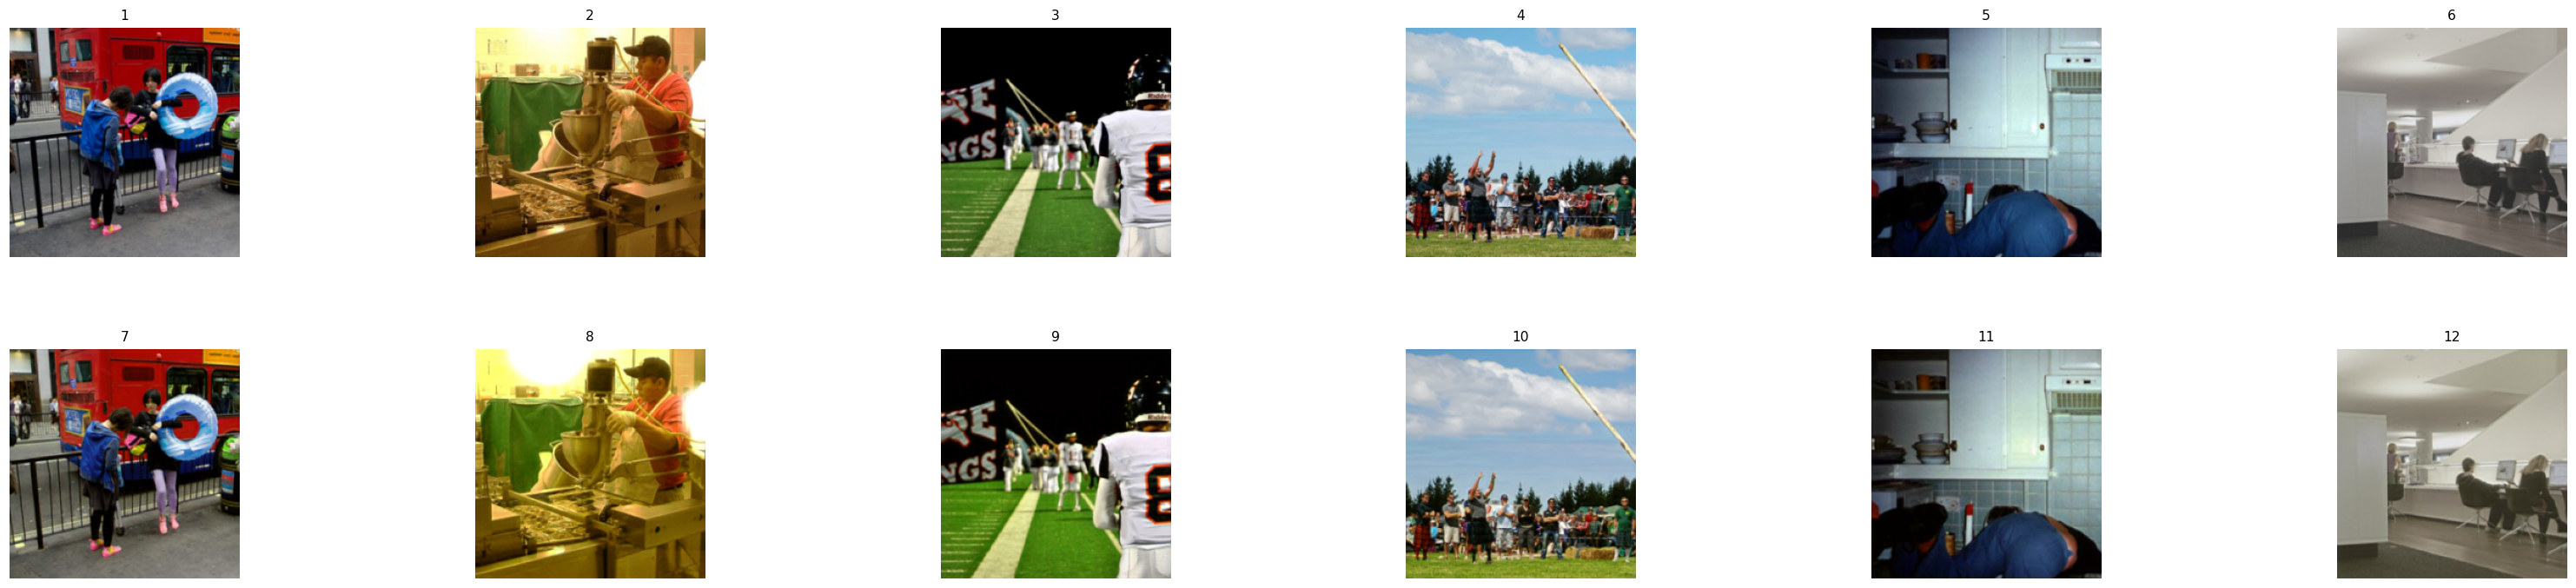

In [60]:
def pretrain_result():
  it = real_generator()
  real_batch = next(it)[:6]
  generated_batch = G(real_batch, training=False)
  to_plot = []
  to_plot.extend(generated_to_images(real_batch))
  to_plot.extend(generated_to_images(generated_batch))
  plot_grid(to_plot, len(real_batch))
pretrain_result()

## Training

In [61]:
learning_rate = cyclical_learning_rate #1e-3
beta1, beta2 = (.5, .99)
weight_decay = 1e-4

In [62]:
discriminator_optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, 
    beta_1=beta1, beta_2=beta2,
    weight_decay=weight_decay
)
generator_optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, 
    beta_1=beta1, beta_2=beta2,
    weight_decay=weight_decay
)

## Model

### Checkpoints & History

In [63]:
local_checkpoint_location = './training_checkpoints/'
history_file_name = 'history.csv'
history_header = ['epoch', 
                  'train_discriminator_loss_mean', 
                  'train_discriminator_loss_std',
                  'train_generator_loss_mean', 
                  'train_generator_loss_std', 
                  'val_discriminator_loss_mean', 
                  'val_discriminator_loss_std',
                  'val_generator_loss_mean', 
                  'val_generator_loss_std', 
                  ]
history_file_path = path.join(local_checkpoint_location, history_file_name)

def reset_history():
  with open(history_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(history_header)

def history_append(epoch, 
                   train_discriminator_loss_mean, 
                   train_discriminator_loss_std, 
                   train_generator_loss_mean, 
                   train_generator_loss_std, 
                   val_discriminator_loss_mean,
                   val_discriminator_loss_std,
                   val_generator_loss_mean,
                   val_generator_loss_std):
  with open(history_file_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow([epoch, 
                   train_discriminator_loss_mean, 
                   train_discriminator_loss_std, 
                   train_generator_loss_mean, 
                   train_generator_loss_std, 
                   val_discriminator_loss_mean,
                   val_discriminator_loss_std,
                   val_generator_loss_mean,
                   val_generator_loss_std])

#### Google Drive checkpoint backup

In [64]:
use_google_drive = False #@param {type:'boolean'}
google_drive_checkpoint_path = 'Anime-Frames/Checkpoints' #@param {type: 'string'}
reset_checkpoints = True #@param {type: 'boolean'}
google_drive_root = '/content/drive/'
google_drive_checkpoint_location = path.join(google_drive_root, 'MyDrive', google_drive_checkpoint_path)
image_directory = os.path.join(local_checkpoint_location, 'images')

if use_google_drive:
  from google.colab import drive
  drive.mount(google_drive_root)
  os.makedirs(google_drive_checkpoint_location, exist_ok=True)
  shutil.rmtree(local_checkpoint_location, ignore_errors=True)
  shutil.copytree(google_drive_checkpoint_location, local_checkpoint_location)
  print(f'Local files at {local_checkpoint_location} will be backed inside {google_drive_checkpoint_location}')
else:
  try:
    drive.flush_and_unmount()
    !rm -rf /content/drive
  except:
    pass


if reset_checkpoints:
  shutil.rmtree(local_checkpoint_location, ignore_errors=True)
if not path.isfile(history_file_path):
  os.makedirs(local_checkpoint_location)
  reset_history()
if (reset_checkpoints):
  !rm -rf $image_directory
!mkdir -p $image_directory

#### Checkpoint manager

In [65]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=G,
                                 discriminator=D,
                                 epoch=tf.Variable(0))
checkpoint_manager = tf.train.CheckpointManager(checkpoint,
                                                local_checkpoint_location,
                                                max_to_keep=10,
                                                keep_checkpoint_every_n_hours=2)

#### Save pretrain

In [66]:
checkpoint_manager.save()

'./training_checkpoints/ckpt-1'

#### Image generation during train

In [67]:
class ImageSaver:
  def __init__(self, epoch_variable, ext='.png', n_columns=4):
    self.columns = n_columns
    self.directory = image_directory
    self.ext = ext
    self.epoch_variable = epoch_variable
    real_gen = real_validation_generator()
    self.real_batch = next(real_gen)[:self.columns]
    cartoon_gen = cartoon_real_validation_generator()
    self.cartoon_batch = next(cartoon_gen)[:n_columns]
    smooth_gen = cartoon_smooth_validation_generator()
    self.smooth_batch = next(smooth_gen)[:n_columns]
  
  def save_images(self, D, G):
    real_images = self.real_batch
    cartoon_images = self.cartoon_batch
    smooth_images = self.smooth_batch

    real_images_G = G(real_images, training=False)
    real_to_cartoon_images = generated_to_images(real_images_G)
    
    generator_list = np.concatenate([generated_to_images(real_images), real_to_cartoon_images])
    
    real_to_cartoon_images_discriminator = self._labels_to_images(D(real_images_G, training=False))
    cartoon_real_discriminator = self._labels_to_images(D(cartoon_images, training=False))
    smooth_discriminator = self._labels_to_images(D(smooth_images, training=False))
    discriminator_list = np.concatenate([cartoon_real_discriminator, smooth_discriminator, real_to_cartoon_images_discriminator])

    save_plot_grid(generator_list, 
                   self.columns, 
                   name=f'generator{self.epoch_variable.numpy()}', 
                   directory=self.directory, 
                   title=f'Epoch {self.epoch_variable.numpy()}', 
                   labels=['Real images', 'Generated images'])
    save_plot_grid(discriminator_list, 
                   self.columns, 
                   name=f'discriminator{self.epoch_variable.numpy()}',
                   directory=self.directory, 
                   title=f'Epoch {self.epoch_variable.numpy()}',
                   labels=['cartoon images', 'smoothed images', 'real images'])
  
  def _labels_to_images(self, labels):
    return tf.sigmoid(labels).numpy().squeeze()

  def _G_to_images(self, images, G):
    return generated_to_images(G(images))

### Implementation

In [71]:
class CartoonGAN:
  def __init__(self,
               checkpoint,
               checkpoint_manager,
               cartoon_real_generator,
               cartoon_smooth_generator,
               real_image_generator,
               smooth_label_generator,
               cartoon_real_generator_val,
               cartoon_smooth_generator_val,
               real_image_generator_val,
               smooth_label_generator_val):
    self.name = 'Cartoon-GAN'
    
    self.checkpoint = checkpoint
    self.checkpoint_manager = checkpoint_manager
    # Checkpoint restore
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    if checkpoint_manager.latest_checkpoint:
      print(f'Restored from {checkpoint_manager.latest_checkpoint}.')
    else:
      print('Initializing from scratch.')
    self.discriminator = checkpoint.discriminator
    self.generator = checkpoint.generator
    self.d_optimizer = checkpoint.discriminator_optimizer
    self.g_optimizer = checkpoint.generator_optimizer

    self.cartoon_real_generator = cartoon_real_generator # cartoon real gen train
    self.cartoon_smooth_generator = cartoon_smooth_generator # cartoon smooth gen train
    self.cartoon_smooth_generator_val = cartoon_smooth_generator_val # cartoon smooth gen val
    self.cartoon_real_generator_val = cartoon_real_generator_val # cartoon real gen val
    self.real_image_generator = real_image_generator # real image gen train
    self.real_image_generator_val = real_image_generator_val # real image gen val
    self.smooth_label_generator = smooth_label_generator # smooth labels train
    self.smooth_label_generator_val = smooth_label_generator_val # smooth labels val
    
    self.batches_per_epoch = min(len(self.cartoon_real_generator), len(self.real_image_generator)) - 1 # Last batch has unknown size
    self.val_batches_per_epoch = min(len(self.cartoon_real_generator_val), len(self.real_image_generator_val)) - 1 # Last batch has unknown size

    self.cartoon_labels = tf.ones((*D.compute_output_shape((batch_size, *input_shape)),))
    self.fake_cartoon_labels = tf.zeros((*D.compute_output_shape((batch_size, *input_shape)),))

    self.d_loss_fn = AdversarialLoss(self.cartoon_labels, self.fake_cartoon_labels)
    self.g_loss_fn = GeneratorLoss(self.cartoon_labels)
    self.bar_format = '{bar}{desc}: {percentage:3.0f}% {r_bar}'

    self.image_saver = ImageSaver(epoch_variable=self.checkpoint.epoch)

  @tf.function
  def _step(self,
              x_cartoon_batch_train,
              x_real_train,
              x_cartoon_smooth_batch_train,
              y_cartoon_smooth_batch_train):
    generated_real_train = self.generator(x_real_train, training=True)

    with tf.GradientTape() as disc_tape:  
      # Discriminator loss
      predictions_cartoon_train = self.discriminator(x_cartoon_batch_train, training=True)
      predictions_generated_train = self.discriminator(generated_real_train, training=True)
      predictions_cartoon_smooth_train = self.discriminator(x_cartoon_smooth_batch_train, training=True)
      d_loss = self.d_loss_fn(predictions_cartoon_train, predictions_generated_train, predictions_cartoon_smooth_train, y_cartoon_smooth_batch_train)
    
    gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(
        zip(gradients_of_discriminator, self.discriminator.trainable_variables)
    )

    with tf.GradientTape() as gen_tape:
      # Generator loss
      generated_real_train = self.generator(x_real_train, training=True)
      generated_real_labels = self.discriminator(generated_real_train, training=True)
      g_loss = self.g_loss_fn(generated_real_train, x_real_train, generated_real_labels)
    
    gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(
        zip(gradients_of_generator, self.generator.trainable_variables)
    )

    return d_loss, g_loss

  @tf.function
  def _val_step(self,
              x_cartoon_batch_val,
              x_real_val,
              x_cartoon_smooth_batch_val,
              y_cartoon_smooth_batch_val):

    generated_real_val = self.generator(x_real_val, training=False)
    
    # Discriminator loss
    predictions_cartoon_val = self.discriminator(x_cartoon_batch_val, training=False)
    predictions_generated_val = self.discriminator(generated_real_val, training=False)
    predictions_cartoon_smooth_val = self.discriminator(x_cartoon_smooth_batch_val, training=False)
    d_loss = self.d_loss_fn(predictions_cartoon_val, predictions_generated_val, predictions_cartoon_smooth_val, y_cartoon_smooth_batch_val)

    # Generator loss (could have been computed from discriminator after one step of training)
    generated_real_labels = self.discriminator(generated_real_val, training=False)
    g_loss = self.g_loss_fn(generated_real_val, x_real_val, generated_real_labels)

    return d_loss, g_loss

  def train(self, epochs):
    starting_epoch = int(self.checkpoint.epoch)
    for epoch in tqdm(range(starting_epoch, epochs),
                      total=epochs,
                      initial=starting_epoch,
                      position=0,
                      desc=f'Training model {self.name}',
                      bar_format=self.bar_format):

      # train phase
      epoch_progress = tqdm(range(self.batches_per_epoch), 
                            total=self.batches_per_epoch, 
                            position=1,
                            desc=f'Training epoch {epoch}',
                            bar_format=self.bar_format)
      train_d_loss_sum = 0
      train_d_loss_sum_squared = 0
      train_g_loss_sum = 0
      train_g_loss_sum_squared = 0
      train_step_count = 0
      
      for (step,
          x_cartoon_batch_train, 
          x_cartoon_smooth_batch_train, 
          x_real_train,
          y_cartoon_smooth_batch_train) in zip(
             epoch_progress,
             self.cartoon_real_generator, 
             self.cartoon_smooth_generator,
             self.real_image_generator,
             self.smooth_label_generator):

        d_loss, g_loss = self._step(x_cartoon_batch_train,
                                    x_real_train,
                                    x_cartoon_smooth_batch_train,
                                    y_cartoon_smooth_batch_train)
        d_loss = d_loss.numpy()
        g_loss = g_loss.numpy()
        
        epoch_progress.set_postfix({
          'Discriminator Loss' : f'{d_loss:.4f}',
          'Generator Loss' : f'{g_loss:.4f}'
        })
        
        train_d_loss_sum += d_loss
        train_d_loss_sum_squared += d_loss * d_loss
        train_g_loss_sum += g_loss
        train_g_loss_sum_squared += g_loss * g_loss
        train_step_count += 1
        
      self.cartoon_real_generator.reset()
      self.cartoon_smooth_generator.reset()
      self.real_image_generator.reset()
      self.smooth_label_generator.reset()
      
      # Compute mean loss and variance for historical data
      train_d_loss_mean = train_d_loss_sum / train_step_count
      train_d_loss_std = np.sqrt(train_d_loss_sum_squared / train_step_count - train_d_loss_mean * train_d_loss_mean)
      train_g_loss_mean = train_g_loss_sum / train_step_count
      train_g_loss_std = np.sqrt(train_g_loss_sum_squared / train_step_count - train_g_loss_mean * train_g_loss_mean)

      # validation phase
      epoch_val_progress = tqdm(total=self.val_batches_per_epoch,
                                position=1,
                                desc=f'Validation epoch {epoch}',
                                bar_format=self.bar_format)
      val_d_loss_sum = 0
      val_d_loss_sum_squared = 0
      val_g_loss_sum = 0
      val_g_loss_sum_squared = 0
      val_step_count = 0
      
      for crgv, csgv, rigv, slgv, _ in zip(self.cartoon_real_generator_val, 
                                     self.cartoon_smooth_generator_val, 
                                     self.real_image_generator_val,
                                     self.smooth_label_generator_val,
                                     range(self.val_batches_per_epoch)):
        
        d_val_loss, g_val_loss = self._val_step(crgv, rigv, csgv, slgv)
        d_val_loss = d_val_loss.numpy()
        g_val_loss = g_val_loss.numpy()
        
        val_d_loss_sum += d_val_loss
        val_d_loss_sum_squared += d_val_loss * d_val_loss
        val_g_loss_sum += g_val_loss
        val_g_loss_sum_squared += g_val_loss * g_val_loss
        val_step_count += 1
        
        epoch_val_progress.update(1)
      
      # Compute mean loss and variance for historical data
      val_d_loss_mean = val_d_loss_sum / val_step_count
      val_d_loss_std = np.sqrt(val_d_loss_sum_squared / val_step_count - val_d_loss_mean * val_d_loss_mean)
      val_g_loss_mean = val_g_loss_sum / val_step_count
      val_g_loss_std = np.sqrt(val_g_loss_sum_squared / val_step_count - val_g_loss_mean * val_g_loss_mean)
      
      epoch_val_progress.set_postfix({
        'Discriminator Loss' : f'{val_d_loss_mean:.4f}',
        'Generator Loss' : f'{val_g_loss_mean:.4f}'
      })
      epoch_val_progress.close()
      
      self.cartoon_real_generator_val.reset()
      self.cartoon_smooth_generator_val.reset()
      self.real_image_generator_val.reset()
      self.smooth_label_generator_val.reset()

      # checkpoint phase
      epoch_checkpoint_progress = tqdm(total=4 if use_google_drive else 3,
                                 position=1,
                                 desc=f'Saving model checkpoints and history for epoch {epoch}',
                                 bar_format=self.bar_format)
      self.checkpoint.epoch.assign_add(1)
      save_path = self.checkpoint_manager.save()
      epoch_checkpoint_progress.update(1)
      epoch_checkpoint_progress.set_description(f'Saved checkpoint for epoch {epoch}: {save_path}')
      
      if use_google_drive:
        shutil.rmtree(google_drive_checkpoint_location)
        shutil.copytree(self.checkpoint_manager.directory, google_drive_checkpoint_location)
        epoch_checkpoint_progress.update(1)
        epoch_checkpoint_progress.set_description(f'Saved checkpoint backup for epoch {epoch}: {save_path} -> {google_drive_checkpoint_location}')
      
      # history save
      history_append(epoch, train_d_loss_mean, train_d_loss_std, train_g_loss_mean, train_g_loss_std, val_d_loss_mean, val_d_loss_std, val_g_loss_mean, val_g_loss_std)
      epoch_checkpoint_progress.update(1)
      epoch_checkpoint_progress.set_description(f'Saved history for epoch {epoch}')

      # training image save
      self.image_saver.save_images(self.discriminator, self.generator)
      epoch_checkpoint_progress.update(1)
      epoch_checkpoint_progress.set_description(f'Saved images for epoch {epoch}')
      
      epoch_checkpoint_progress.close()


In [72]:
model = CartoonGAN(checkpoint,
                   checkpoint_manager,
                   cartoon_real_generator(), 
                   cartoon_smooth_generator(), 
                   real_generator(),
                   smooth_label_generator(),
                   cartoon_real_validation_generator(),
                   cartoon_smooth_validation_generator(),
                   real_validation_generator(),
                   smooth_label_validation_generator())

Found 20924 images belonging to 10 classes.
Found 20924 images belonging to 10 classes.
Found 36645 images belonging to 1 classes.
Found 20924 images belonging to 10 classes.
Found 5224 images belonging to 10 classes.
Found 5224 images belonging to 10 classes.
Found 9161 images belonging to 1 classes.
Found 5224 images belonging to 10 classes.
Restored from ./training_checkpoints/ckpt-2.
Found 9161 images belonging to 1 classes.
Found 5224 images belonging to 10 classes.
Found 5224 images belonging to 10 classes.


### Training

In [73]:
model.train(30)

3         Training model Cartoon-GAN:   3% | 1/30 [00:00<?, ?it/s]

          Training epoch 1:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 1:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 1:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 2:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 2:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 2:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 3:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 3:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 3:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 4:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 4:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 4:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 5:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 5:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 5:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 6:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 6:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 6:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 7:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 7:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 7:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 8:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 8:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 8:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 9:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 9:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 9:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 10:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 10:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 10:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 11:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 11:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 11:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 12:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 12:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 12:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 13:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 13:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 13:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 14:   0% | 0/1307 [00:00<?, ?it/s]

          Validation epoch 14:   0% | 0/326 [00:00<?, ?it/s]

          Saving model checkpoints and history for epoch 14:   0% | 0/3 [00:00<?, ?it/s]

          Training epoch 15:   0% | 0/1307 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Training Gif

In [ ]:
def create_gif(directory, filter='', name=None):
  if name is None:
    name = filter if len(filter) > 0 else 'gif'
  g = [
      (Image.open(os.path.join(root, name)), image_name_to_number(name))
      for root, dirs, files in os.walk(directory)
      for name in files
      if filter in name
  ]
  b = list(map(lambda x: x[0], sorted(g, key=lambda x: x[1])))

  b[0].save(
      f"{filter}.gif",
      save_all=True,
      append_images=b[1:],
      optimize=False,
      duration=600,
      loop=0,
  )

create_gif(image_directory, 'generator')
create_gif(image_directory, 'discriminator')

In [ ]:
ImageGif(open('generator.gif','rb').read())

In [ ]:
ImageGif(open('discriminator.gif','rb').read())

In [ ]:
cartoon_images = next(cartoon_real_generator())
cartoon_smoothed_images = next(cartoon_smooth_generator())
black_images = np.full((2, 224, 224, 3), 0.0)

print('cartoon')
plot_grid(D(cartoon_images).numpy().squeeze(), 4)
print('smoothed')
plot_grid(D(cartoon_smoothed_images).numpy().squeeze(), 4)
print('black')
plot_grid(D(black_images).numpy().squeeze(), 2)

In [ ]:
real_images = next(real_generator())
black_images = np.full((4, 224, 224, 3), 0.0)

print('real images')
plot_grid(generated_to_images(real_images), 4)
print('cartoon generated')
plot_grid(generated_to_images(G(real_images)), 4)
print('black')
plot_grid(generated_to_images(G(black_images)), 4)

### Plot result

In [ ]:
df = pd.read_csv(history_file_path, sep=',', header=0)
df = df.set_index('epoch')

fig, ax1 = plt.subplots(1, figsize=(20,15))
x = df.index
ax1.set_xlabel('Epochs', fontsize=15)

mean_d, std_d = ('train_discriminator_loss_mean', 'train_discriminator_loss_std')
mean_g, std_g = ('train_generator_loss_mean', 'train_generator_loss_std')
val_mean_d, val_std_d = ('val_discriminator_loss_mean', 'val_discriminator_loss_std')
val_mean_g, val_std_g = ('val_generator_loss_mean', 'val_generator_loss_std')

# plot discriminator training
y = df[mean_d]
err = df[std_d]
line, = ax1.plot(x, y, label=mean_d, color='orange')
ax1.fill_between(x, y - err, y + err, alpha=0.05, color=line.get_color())
ax1.set_ylabel('Discriminator loss', fontsize=20, color = line.get_color())

# plot discriminator validation
y = df[val_mean_d]
err = df[val_std_d]
line, = ax1.plot(x, y, '--', label=val_mean_d, color='orangered')
ax1.fill_between(x, y - err, y + err, alpha=0.05, color=line.get_color())

_ = ax1.legend(loc='lower left', fontsize=15)

ax2=ax1.twinx()

y = df[mean_g]
err = df[std_g]
line, = ax2.plot(x, y, label=mean_g, color='deepskyblue')
ax2.fill_between(x, y - err, y + err, alpha=0.05, color=line.get_color())
ax2.set_ylabel('Generator loss', fontsize=20, color = line.get_color())

# plot discriminator validation
y = df[val_mean_g]
err = df[val_std_g]
line, = ax2.plot(x, y, '--', label=val_mean_g, color='blue')
ax2.fill_between(x, y - err, y + err, alpha=0.05, color=line.get_color())

_ = ax2.legend(loc='upper right', fontsize=15,)

plt.rcParams['axes.facecolor'] = 'white'